# 4.2.2 Capstone Analytic Report and Research Proposal

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from scipy.stats import ttest_ind
%matplotlib inline



## Data Set Description
by: Salil Ketkar

#### Data Source: https://data.lacounty.gov/Health/LOS-ANGELES-COUNTY-RESTAURANT-AND-MARKET-INSPECTIO/6ni6-h5kp

#### Context:  

The dataset contains data from restaurant and market health evaluations from the county of Los Angeles.  All inspections were performed in 2015 to 2018.  Data will be analzyed and visualized to answer the following questions:

1. How do grades/scores vary across zipcodes? How do zip codes rank in terms of average scores? 
2. Does the risk given to each restaurant accurately represent the score received?
3. How do the scores of chain restaurants compare to score of local spots?  For example, chipotle mexican grill v. local mexican restaurants.  



#### Abbreviations and Scales: 
serial_number - unique ID for each inspection (string) activity_date - date of inspection (date: yyyy/mm/dd format) facility_name - name of facility (string) score - the score of the inpsection (integer 0 to 100) grade - the grade of the inspection (string A to F) service_code - identifies the service performed (string) service description - describes the service that was performed (string) employee_ID - id number of the employee who performed the inspection (string) facility_address - address of the facility (string) facility_city - address of the facility (string) 
facility_ID - represents a specific facility record (string) facility_state - state of the facility (string) facility_zip - zip code of the facility (integer) owner_id - represents a specific owner record (string) owner_name - name of the legal owner (string) pe_description - describes the type of program (string) program_element_pe - the code identifies the type of program (string) program_name - A unique name for each program. There may be more than one program at a facility (string) program_status - indicates the status of the program (string) record_id - 	
Unique ID number for each health program at a facility



In [166]:
#upload csv containing data set provided by LA county

la_inspections = pd.read_csv('/Users/salilketkar/thinkful/LA_health_score_inspections.csv')

Raw health inspection data was provided by the County of Los Angeles.  The data was cleaned to remove unnecessary characters and make formatting consistent.  A new data set called 'la_inspections_new' was created which contains columns relevant for this data analysis.  Below is a boxplot that shows the spread of all health inspection scores with an interquartile range of 84 to 100.  This range will be considered when performing analyses later on.   

In [167]:
#formatting data
la_inspections['facility_city'] = la_inspections['facility_city'].str.title()
la_inspections['pe_description'] = la_inspections['pe_description'].str.title()

#shorten zip code to be 5 numbers and date follow yyyy-mm-dd format
la_inspections['facility_zip_short'] = la_inspections['facility_zip'].apply(lambda x: x[:5])
la_inspections['activity_date_short'] = la_inspections['activity_date'].apply(lambda x: x[:10])
la_inspections['facility_name_new'] = la_inspections['facility_name'].apply(lambda x: x.replace("'",""))
la_inspections['facility_name_new'] = la_inspections['facility_name_new'].str.title()

#creating new dataset with relevant columns
la_inspections_new = la_inspections[['activity_date_short','facility_name_new','score','grade','facility_city','facility_state',
                                     'facility_zip_short','pe_description','facility_id']]
la_inspections_new.head()

,activity_date_short,facility_name_new,score,grade,facility_city,facility_state,facility_zip_short,pe_description,facility_id
0,2017-12-29,Habitat Coffee Shop,95,A,Los Angeles,CA,90065,Restaurant (0-30) Seats Moderate Risk,FA0170465
1,2017-12-29,Reillys,92,A,Los Angeles,CA,90045,Restaurant (0-30) Seats Moderate Risk,FA0244690
2,2017-12-29,Street Churros,93,A,Los Angeles,CA,90028,Restaurant (0-30) Seats Low Risk,FA0224109
3,2017-12-29,Rio Gentlemans Club,93,A,Los Angeles,CA,90064,Restaurant (61-150) Seats Low Risk,FA0046462
4,2017-12-29,Le Pain Quotidien,93,A,Los Angeles,CA,90049,Restaurant (61-150) Seats High Risk,FA0034788


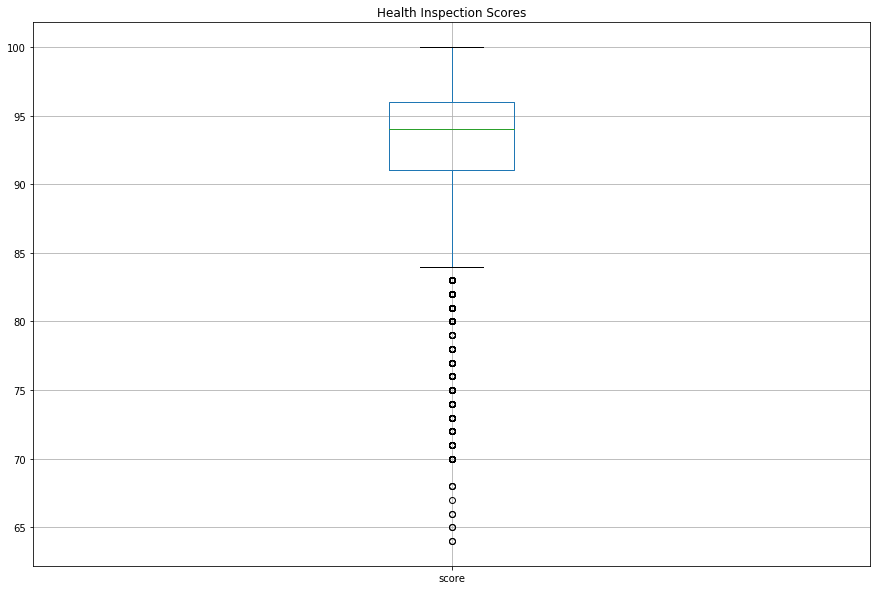

In [6]:
#create boxplot to determine how scores are distributed
plt.figure(figsize=(15, 10))
la_inspections_new.boxplot('score')
plt.title("Health Inspection Scores")
plt.show()

## Question 1:
How does the number of restaurants inspected across the whole county vary by zip code? How do zip codes rank in terms of average scores? 

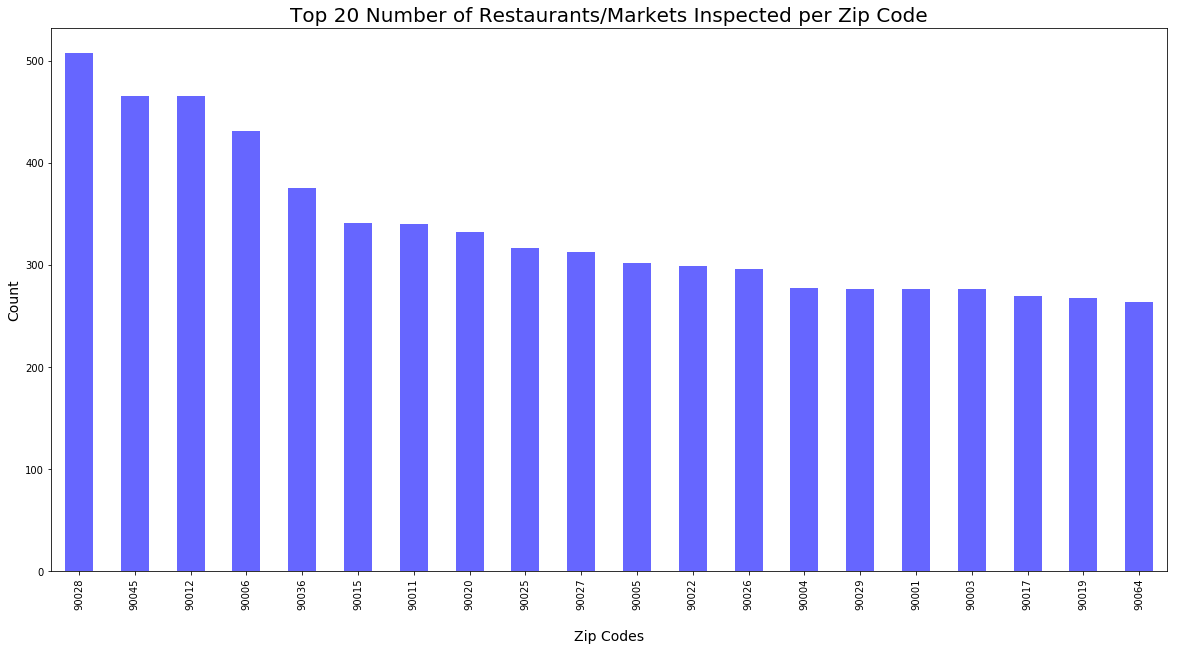

In [95]:
#create bar graph to show what zipcodes have the most restaurants that were inspected.  No duplicates
la_inspections_facilityID = la_inspections_new.groupby(['facility_id', 'facility_zip_short']).size().reset_index(name='Freq')

#Create a pnd series of zip code sorted by number of facility_id (Freq)
Freq=la_inspections_facilityID.groupby('facility_zip_short').count()['Freq'].sort_values(axis=0, ascending=False)

plt.figure(figsize=(20, 10))
Freq.nlargest(20).plot(kind='bar',color='blue',alpha=0.6)
plt.xlabel('Zip Codes',fontsize=14, labelpad=20)
plt.ylabel('Count',fontsize=14)
plt.title('Top 20 Number of Restaurants/Markets Inspected per Zip Code', fontsize=20)
plt.show()

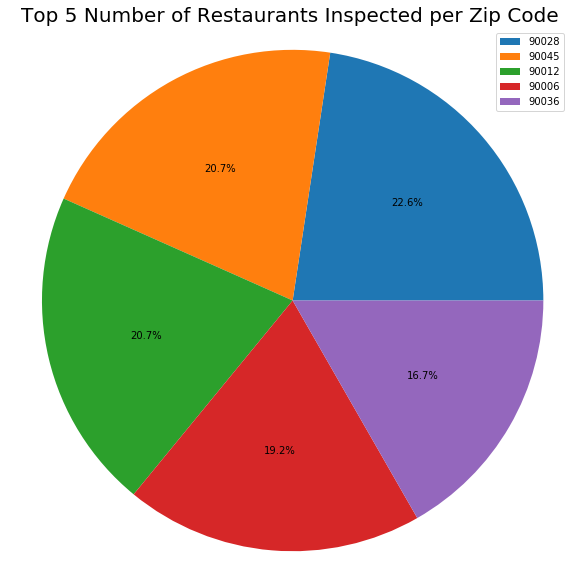

In [152]:
Freq.reset_index()
plt.figure(figsize=(10, 10))
plt.pie(Freq.nlargest(5),autopct='%1.1f%%')
plt.legend(['90028','90045','90012','90006','90036'], loc="best")
plt.title('Top 5 Number of Restaurants Inspected per Zip Code',fontsize=20)
plt.axis('equal')  
plt.show()



Since the same restaurants were inspected multiple times over the course of 4 years, the bar graph above shows the  zip codes with the top 20 highest number of unique restaurants.  The zip code with the highest number of restaurants insepcted is 90028 which represents the Hollywood area.  Given the densely populated and touristy neighborhood this is, it is no suprise it ranks first.  The second and third ranked zip codes are the area surrounding Los Angeles International Airport and Chinatown, respectively.  The restaurants in the top 20 zip codes represent just over 50% of the total number inspected.

The pie chart above shows the percentages of restaurants inspected in the top 5 zip codes.  These zip codes make up just over 17% of the unique restaurants inspected.



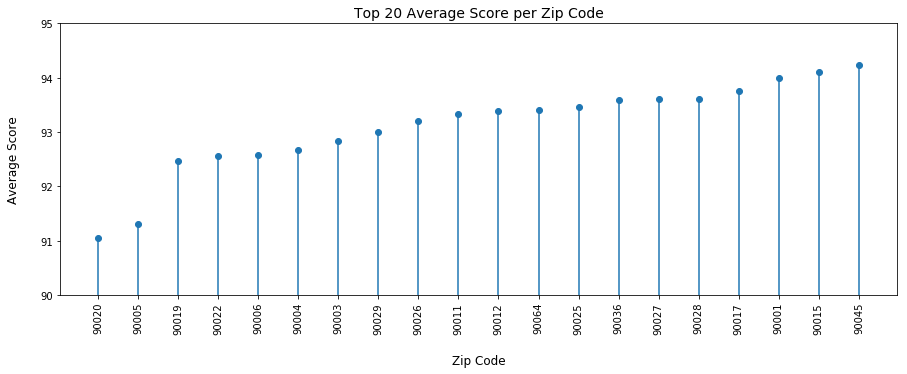

In [138]:
#create bar graph to show what zipcodes have the most restaurants that were inspected.  No duplicates
la_inspections_facilityID = la_inspections_new.groupby(['facility_id', 'facility_zip_short']).size().reset_index(name='Freq')

#Create a pnd series of zip code sorted by number of facility_id (Freq)
Freq=la_inspections_facilityID.groupby('facility_zip_short').count()['Freq'].sort_values(axis=0, ascending=False)

#ranking zipcodes based on average score
df_rank =la_inspections_new.groupby('facility_zip_short')['score'].agg(['mean'])
rank = df_rank.join(Freq)
rank = rank.nlargest(20,'Freq').sort_values('mean',ascending=True).reset_index()

plt.figure(figsize=(15, 5))
plt.stem(rank['mean'])
plt.ylim(90,95)
plt.xticks(np.arange(20),rank['facility_zip_short'],rotation='vertical')
plt.title('Top 20 Average Score per Zip Code',size=14)
plt.ylabel('Average Score', size=12,labelpad=20)
plt.xlabel('Zip Code', size=12,labelpad=20)
plt.show()

The stem plot above shows the ranking of ascending average scores per zip code.  The zip code with the highest average score at 94.23 is 90045.  This zip code has the second highest number of restaurants inspected.  To reiterate, restaurants were inspected multiple times throughout the course of 4 years so only the top 20 zip codes with the highest freqency of unique restaurants were considered for this ranking.

## Question 2:
Does the risk given to each restaurant play a factor in the score?

For backgroud, the county of Los Angeles has classified each restaurant in this data set as 'Low', 'Moderate' or 'High' risk.  This classification can be found in the 'pe_description' column.  It is expected that the low risk restaurants will pose the least threat to health and safety and therefore should receive a higher score.  

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

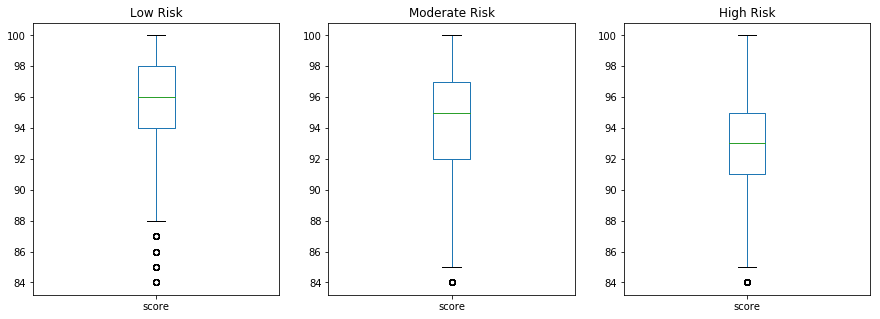

Low Risk v. Moderate Risk Ttest_indResult(statistic=30.816491609451305, pvalue=7.254275371272163e-204)
Low Risk v. High Risk Ttest_indResult(statistic=71.599149497724, pvalue=0.0)
Moderate Risk v. High Risk Ttest_indResult(statistic=38.041296528906365, pvalue=4.0525892314997216e-307)


In [169]:
#creating boxplots for scores of restarurants that were classified as low, medium, and high risk to determine if 
#there is any significant change in the scores.  

la_inspections_new['pe_description_low']=la_inspections_new['pe_description'].apply(lambda x: x.find('Low Risk')>0)
la1 = la_inspections_new[(la_inspections_new['pe_description_low'] == True)]
la1= la1[(la1['score']>=84)]
la1.sort_values('score',ascending=True).head()

la_inspections_new['pe_description_mod']=la_inspections_new['pe_description'].apply(lambda x: x.find('Moderate Risk')>0)
la2 = la_inspections_new[(la_inspections_new['pe_description_mod'] == True)]
la2= la2[(la2['score']>=84)]
la2.sort_values('score',ascending=True).head()

la_inspections_new['pe_description_high']=la_inspections_new['pe_description'].apply(lambda x: x.find('High Risk')>0)
la3 = la_inspections_new[(la_inspections_new['pe_description_high'] == True)]
la3= la3[(la3['score']>=84)]
la3.sort_values('score',ascending=True).head()

fig = plt.figure(figsize=(15, 5))

fig.add_subplot(1,3,1)
la1['score'].plot(kind='box',title='Low Risk')


fig.add_subplot(1,3,2)
la2['score'].plot(kind='box',title='Moderate Risk')


fig.add_subplot(1,3,3)
la3['score'].plot(kind='box',title='High Risk')
plt.show()

print('Low Risk v. Moderate Risk',ttest_ind(la1['score'], la2['score'], equal_var=False))
print('Low Risk v. High Risk',ttest_ind(la1['score'], la3['score'], equal_var=False))
print('Moderate Risk v. High Risk',ttest_ind(la2['score'], la3['score'], equal_var=False))

As originally predicted, the low risk restaurants have a higher score and the high risk restaurants have a lower score.  The extremely low p-value in all three t-tests indicate that the difference in means is due to a real difference in the population.  The classification of risk plays a factor in the health inspection score.  

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

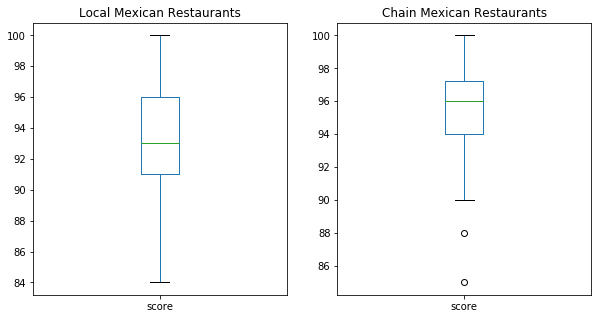

Local v. Chain Mexican Restaurants Ttest_indResult(statistic=-7.608976967937611, pvalue=1.678931913442233e-12)


In [173]:
#comparing local mexican restaurants to chain mexican
#some local mexican restaurants

la_inspections_new['localmex']=la_inspections_new['facility_name_new'].apply(lambda x: x.find(('Taco' or 'Mexican'))>=0)
la_inspections_new['notlocalmex']=la_inspections_new['facility_name_new'].apply(lambda x: x.find('Taco Bell' or 'Mexican Grill' or 'Del Taco')>=0)
localMex = la_inspections_new[(la_inspections_new['localmex'] == True) & (la_inspections_new['notlocalmex'] == False)]
localMex = localMex[(localMex['score']>=84)]


#some chain mexican restaurants
la_inspections_new['chainmex']=la_inspections_new['facility_name_new'].apply(lambda x: x.find('Chipotle' or 'Taco Bell' or 'Qdoba' or 'Del Taco')>=0)                                                                                                      
chainMex = la_inspections_new[(la_inspections_new['chainmex'] == True)]
chainMex = chainMex[(chainMex['score']>=84)]


#create boxplot and t-test for this comparison
fig = plt.figure(figsize=(10, 5))

fig.add_subplot(1,2,1)
localMex['score'].plot(kind='box',title='Local Mexican Restaurants')

fig.add_subplot(1,2,2)
chainMex['score'].plot(kind='box',title='Chain Mexican Restaurants')

plt.show()

print('Local v. Chain Mexican Restaurants',ttest_ind(localMex['score'], chainMex['score'], equal_var=False))

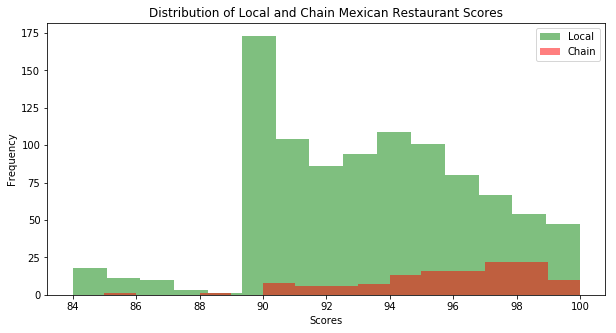

In [142]:
#histogram for local and chain mexican restaurants to show how data is distributed

fig = plt.figure(figsize=(10, 5))
localMex['score'].plot(kind='hist',bins=15,alpha=0.5, color='green')
chainMex['score'].plot(kind='hist',bins=15,alpha=0.5, color='red')
plt.title('Distribution of Local and Chain Mexican Restaurant Scores')
plt.xlabel('Scores')
plt.legend(['Local','Chain'], loc='best')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

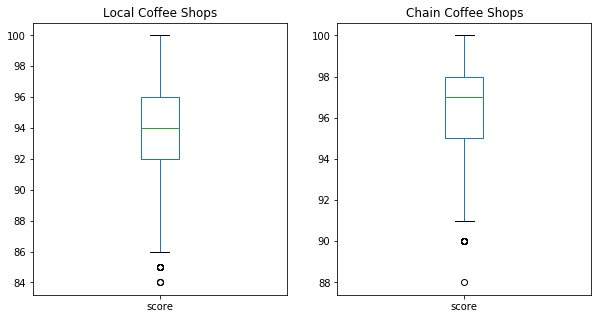

Local v. Chain Coffee Shops Ttest_indResult(statistic=-13.812462178588751, pvalue=2.5634439789520834e-38)


In [174]:
#comparing local restaurants to chain 
#some local coffee shops

la_inspections_new['localcoffee']=la_inspections_new['facility_name_new'].apply(lambda x: x.find(('Coffee' or 'Coffee Shop' or 'Cafe'))>=0)
la_inspections_new['notlocalcoffee']=la_inspections_new['facility_name_new'].apply(lambda x: x.find(('Starbucks' or 'Tea Leaf' or 'Peets'))>=0)
localCoffee = la_inspections_new[(la_inspections_new['localcoffee'] == True) & (la_inspections_new['notlocalcoffee'] == False)]
localCoffee = localCoffee[(localCoffee['score']>=84)]


#some chain coffee restaurants
la_inspections_new['chaincoffee']=la_inspections_new['facility_name_new'].apply(lambda x: x.find('Starbucks' or 'Coffee Bean ' or 'Peets')>=0)                                                                                                      
chainCoffee = la_inspections_new[(la_inspections_new['chaincoffee'] == True)]
chainCoffee = chainCoffee[(chainCoffee['score']>=84)]


#create boxplot and t-test for this comparison
fig = plt.figure(figsize=(10, 5))

fig.add_subplot(1,2,1)
localCoffee['score'].plot(kind='box',title='Local Coffee Shops')

fig.add_subplot(1,2,2)
chainCoffee['score'].plot(kind='box',title='Chain Coffee Shops')

plt.show()

print('Local v. Chain Coffee Shops',ttest_ind(localCoffee['score'], chainCoffee['score'], equal_var=False))

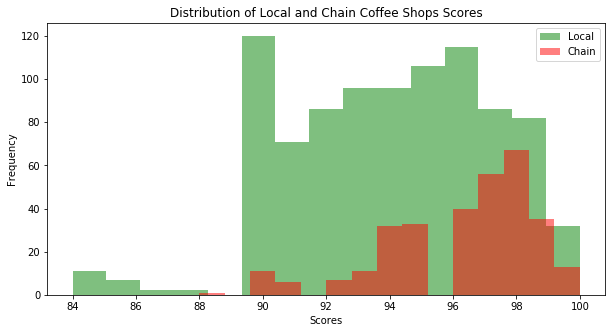

In [176]:
#histogram for local and chain coffee shops to show how data is distributed

fig = plt.figure(figsize=(10, 5))
localCoffee['score'].plot(kind='hist',bins=15,alpha=0.5, color='green')
chainCoffee['score'].plot(kind='hist',bins=15,alpha=0.5, color='red')
plt.title('Distribution of Local and Chain Coffee Shops Scores')
plt.xlabel('Scores')
plt.legend(['Local','Chain'], loc='best')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


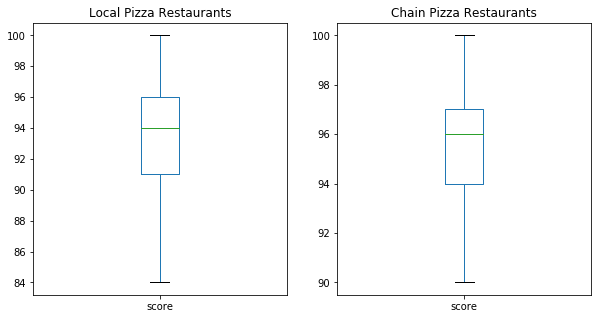

Local v. Chain Pizza Restaurants Ttest_indResult(statistic=-10.756230014528787, pvalue=2.0014390359451432e-22)


In [175]:
#comparing local restaurants to chain 
#some local pizza restuarants 

la_inspections_new['localpizza']=la_inspections_new['facility_name_new'].apply(lambda x: x.find('Pizza')>=0)
la_inspections_new['notlocalpizza']=la_inspections_new['facility_name_new'].apply(lambda x: x.find('Pizza Hut' or 'Dominos Pizza' or 'Pizza Kitchen' or 'Papa Johns')>=0)
localPizza = la_inspections_new[(la_inspections_new['localpizza'] == True) & (la_inspections_new['notlocalpizza'] == False)]
localPizza = localPizza[(localPizza['score']>=84)]


#some chain pizza restaurants
la_inspections_new['chainpizza']=la_inspections_new['facility_name_new'].apply(lambda x: x.find(('Pizza Hut' or 'Dominos Pizza' or 'Pizza Kitchen' or 'Papa Johns Pizza'))>=0)                                                                                                      
chainPizza = la_inspections_new[(la_inspections_new['chainpizza'] == True)]
chainPizza = chainPizza[(chainPizza['score']>=84)]


#create boxplot and t-test for this comparison
fig = plt.figure(figsize=(10, 5))

fig.add_subplot(1,2,1)
localPizza['score'].plot(kind='box',title='Local Pizza Restaurants')

fig.add_subplot(1,2,2)
chainPizza['score'].plot(kind='box',title='Chain Pizza Restaurants')

plt.show()

print('Local v. Chain Pizza Restaurants',ttest_ind(localPizza['score'], chainPizza['score'], equal_var=False))

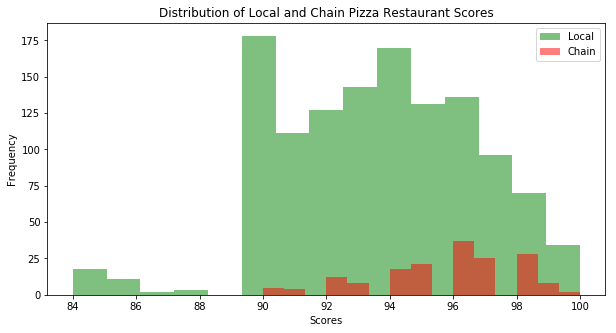

In [144]:
#histogram for local and chain pizza restaurants to show how data is distributed

fig = plt.figure(figsize=(10, 5))
localPizza['score'].plot(kind='hist',bins=15,alpha=0.5, color='green')
chainPizza['score'].plot(kind='hist',bins=15,alpha=0.5, color='red')
plt.title('Distribution of Local and Chain Pizza Restaurant Scores')
plt.xlabel('Scores')
plt.legend(['Local','Chain'], loc='best')
plt.show()

## Proposed Further Analysis:

   1.  Given the recent bacterial outbreaks that occurred at various chain restaurants (Chipotle, McDonald's), it would be interesting to know how that impacted health inspection scores around the time of the incident and even a year later.  Would this have caused other restaurants to be even more cautitous when trying to comply with health and safety procedures?  
   2.  Comparisons were done between local and chain restaurants for mexican food, pizza, and coffee shops.  How do other cuisines compare on a local and national level.  Solely based on the name, it is hard to filter what is a chain and what is not.  If the county provided information on cuisine that would make this feasible.  
   3.  What other factors contribute to a low or high health inspection score.  If more data was provided on number of employees or average pay rates, this could be investigated further.  It would be interested to find out how scores of franchised restaurants compare with restaurants that are unable to be franchised. 